In [22]:
import numpy as np
import pygame
import random
import math
from matplotlib import pyplot as plt

BLUE  = (0,0,255)
WHITE = (255,255,255)
BLACK = (0,0,0)
RED   = (255,0,0)

coefficients         = {}
coefficients['eta0'] = 1.0000
coefficients['wght'] = 0.0196
coefficients['eta1'] = 3.9804
coefficients['eta2'] = 0.2157
coefficients['eta3'] = 3.2353
coefficients['eta4'] = 0.5098
params               = {}
params['migration_exists'] = True
params['migration_coeff']  = 0.15
params['number_of_iter']   = 100
params['use_saved_data']   = False

class swarm():
    def __init__(self, func, lowerbounds=[], upperbounds=[], number_of_particles=30, display=True):
        self.lowerbounds  = lowerbounds
        self.upperbounds  = upperbounds
        self.nop          = number_of_particles
        self.display      = display
        self.func         = func
        self._vel_max     = 20.0
        self._vel_min     = -20.0
        self.member       = {}
        
        if self.func.__name__   == 'egg':
            self.lowerbounds  = [-512,-512]
            self.upperbounds  = [512,512]
        elif self.func.__name__ == 'griewank':
            self.lowerbounds  = [-600,-600]
            self.upperbounds  = [600,600]
        
        if self.display:
            self.screen       = pygame.display.set_mode((1000, 1000))
            pygame.display.set_caption("Particle Swarm Optimization")
            self.screen.fill(WHITE)
                    
        for ii in range(self.nop):
            self.member[str(ii)] = {'center':(0,0)}
            self.member[str(ii)]['best_value'] = 10**5
            
            self.member[str(ii)]['position']      = {str(jj): np.random.random()*\
                                                    (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                     self.lowerbounds[jj] for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['best_position'] = {str(jj): np.random.random()*\
                                                    (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                     self.lowerbounds[jj] for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['velocity']      = {str(jj): np.random.random()\
                                                     for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['center'] = (int(np.round(self.member[str(ii)]['position']['0'])),
                                              int(np.round(self.member[str(ii)]['position']['1'])))
        
        self.evaluate_fitness()
        self.distance()
        
    def evaluate_fitness(self):
        '''evaluates the fitness function for the members of the swarm'''
        self.fitness_values = {'_'           :{},
                               'sorted'      :{},
                               'best'        :{},
                               'best_sorted' :{}}
        for ii in range(self.nop):
            self.member[str(ii)]['fitness_value'] = self.func([self.member[str(ii)]\
                                                    ['position'][str(jj)] for jj in\
                                                    range(len(self.lowerbounds))])
            
            if self.member[str(ii)]['fitness_value']<self.member[str(ii)]['best_value']:
                self.member[str(ii)]['best_value']            = self.member[str(ii)]['fitness_value']
                for jj in range(len(self.lowerbounds)):
                    self.member[str(ii)]['best_position'][str(jj)] = self.member[str(ii)]['position'][str(jj)]
        
            self.fitness_values['_'][str(ii)]    = self.member[str(ii)]['fitness_value']
            self.fitness_values['best'][str(ii)] = self.member[str(ii)]['best_value']

        self._sorted_fitness_value    = sorted(self.fitness_values['_'].items(), key = lambda kv:(kv[1], kv[0]))
        self.fitness_values['sorted'] = {str(self._sorted_fitness_value[ii][0]):self._sorted_fitness_value[ii][1]\
                                         for ii in range(self.nop)}
        
        self._sorted_best_value       = sorted(self.fitness_values['best'].items(), key = lambda kv:(kv[1], kv[0]))
        self.fitness_values['best_sorted'] = {str(self._sorted_best_value[ii][0]):self._sorted_best_value[ii][1]\
                                              for ii in range(self.nop)}
        
        self.best_position = {list(self.fitness_values['best_sorted'].keys())[ii]:\
                              self.member[list(self.fitness_values['best_sorted'].keys())[ii]]['best_position']\
                              for ii in range(self.nop)}
            
    def distance(self):
        '''calculates the distances between the members of the swarm'''
        for ii in range(self.nop):
            self.member[str(ii)]['distance'] = {str(jj): {str(kk): self.member[str(ii)]['position'][str(kk)]-\
                                                         self.member[str(jj)]['position'][str(kk)]\
                                                         for kk in range(len(self.lowerbounds))}\
                                                         for jj in range(self.nop)}
            
            self.member[str(ii)]['distance_sorted'] = {str(jj):sorted(np.abs(self.member[str(ii)]['distance']\
                                                      [str(kk)][str(jj)]) for kk in range(self.nop)) for jj in\
                                                       range(len(self.lowerbounds))}
            
            self.member[str(ii)]['abs_distance'] = {str(jj): np.sqrt(math.fsum(self.member[str(ii)]['distance']\
                                                             [str(jj)][str(kk)]**2 for kk in\
                                                             range(len(self.lowerbounds)))) for jj in\
                                                             range(self.nop)}
            
            self.member[str(ii)]['abs_distance_sorted'] = [sorted(self.member[str(ii)]['abs_distance'].items(),\
                                                          key = lambda kv:(kv[1], kv[0]))[jj][1] for jj in\
                                                          range(self.nop)]
            
            self.member[str(ii)]['closest_neighbours'] = [sorted(self.member[str(ii)]['abs_distance'].items(),\
                                                          key = lambda kv:(kv[1], kv[0]))[jj][0] for jj in\
                                                          range(self.nop)]
            
            self.member[str(ii)]['closest_neighbours_fitness_values'] = {self.member[str(ii)]['closest_neighbours'][jj]:\
                                                                         self.member[self.member[str(ii)]['closest_neighbours'][jj]]['fitness_value']\
                                                                         for jj in range(self.nop)}
            
            self.member[str(ii)]['closest_neigbours_best'] = sorted(list(self.member[str(ii)]\
                                                                 ['closest_neighbours_fitness_values'].items())[1:5],
                                                                 key=lambda kv:(kv[1],kv[0]))[0][0]
            
            '''distance from the closest particle which has the best fitness value'''
            self.member[str(ii)]['distance_from_closest_best'] = self.member[str(ii)]['distance']\
                                                                [self.member[str(ii)]['closest_neigbours_best']]
    
    def optimize(self):
        '''PSO algoritm'''
        for ii in range(self.nop):
            for jj in range(len(self.lowerbounds)):
                self.member[str(ii)]['velocity'][str(jj)] =  coefficients['eta0'] * (coefficients['wght'] * \
                                                             self.member[str(ii)]['velocity'][str(jj)]) + \
                                                             coefficients['eta1'] * np.random.random() * \
                                                             self.member[str(ii)]['best_position'][str(jj)] - \
                                                             self.member[str(ii)]['position'][str(jj)] + \
                                                             coefficients['eta2'] * np.random.random() * \
                                                             list(self.best_position.values())[0][str(jj)] - \
                                                             self.member[str(ii)]['position'][str(jj)] + \
                                                             coefficients['eta3'] * np.random.random() * \
                                                             list(self.member[str(ii)]['distance_sorted'].values())[jj][1] + \
                                                             coefficients['eta4'] * np.random.random() * \
                                                             self.member[str(ii)]['distance_from_closest_best'][str(jj)]
        
                if self.member[str(ii)]['velocity'][str(jj)] > self._vel_max:
                    self.member[str(ii)]['velocity'][str(jj)] = self._vel_max
                elif self.member[str(ii)]['velocity'][str(jj)] < self._vel_min:
                    self.member[str(ii)]['velocity'][str(jj)] = self._vel_min
                    
                self.member[str(ii)]['position'][str(jj)] = self.member[str(ii)]['position'][str(jj)] + \
                                                            self.member[str(ii)]['velocity'][str(jj)]
                
                if self.member[str(ii)]['position'][str(jj)] > self.upperbounds[jj]:
                    self.member[str(ii)]['position'][str(jj)] = self.upperbounds[jj]
                elif self.member[str(ii)]['position'][str(jj)] < self.lowerbounds[jj]:
                    self.member[str(ii)]['position'][str(jj)] = self.lowerbounds[jj]

                    
    def update(self): 
        '''updates the position and velocity of the members of the swarm'''
        self.optimize()
        self.evaluate_fitness()
        self.distance()
        
        for ii in range(self.nop):
            self.member[str(ii)]['center'] = (int(np.round(self.member[str(ii)]['position']['0'])),
                                              int(np.round(self.member[str(ii)]['position']['1'])))
            if self.display:
                pygame.draw.circle(self.screen,BLUE,self.member[str(ii)]['center'],2)

        if self.display:
            pygame.display.flip()     
            self.screen.fill(WHITE)

In [27]:
def egg(*args):
    x1    = args[0][0]
    x2    = args[0][1]
    term1 = -(x2+47) * math.sin(math.sqrt(math.fabs(x2+x1/2+47)))
    term2 = -x1 * math.sin(math.sqrt(math.fabs(x1-(x2+47))))
    out   = term1 + term2
    return out

def griewank(*args):
    d    = len(args[0])
    sum  = 0
    prod = 1
    for ii in range(d):
        xi   = args[0][ii]
        sum  = sum + xi**2/4000
        prod = prod * math.cos(xi/math.sqrt(ii+1))
    out = sum - prod + 1
    return out

def bukin6(*args):
    x1 = args[0][0]
    x2 = args[0][1]    
    term1 = 100 * math.sqrt((abs(x2-0.01*x1**2)))
    term2 = 0.01 * abs(x1+10)    
    out = term1 + term2
    return out

def ackley(*args):
    d    = len(args[0])
    c    = math.pi * 2
    b    = 0.20
    a    = 20
    
    sum1 = 0
    sum2 = 0
    
    for ii in range(d):
        xi   = args[0][ii]
        sum1 = sum1 + xi**2
        sum2 = sum2 + math.cos(c*xi)
    
    term1 = -a * math.exp(-b*math.sqrt(sum1/d))
    term2 = -math.exp(sum2/d)
    
    y = term1 + term2 + a + math.exp(1)
    
    return y

def drop(*args):
    x1 = args[0][0]
    x2 = args[0][1]
    frac1 = 1+math.cos(12*math.sqrt(x1**2 + x2**2))
    frac2 = 0.5*(x1**2 + x2**2) + 2
    out = -frac1/frac2
    return out

In [28]:
fitness_function             = {}
fitness_function['egg']      = egg
fitness_function['griewank'] = griewank
fitness_function['bukin6']   = bukin6
fitness_function['ackley']   = ackley
fitness_function['drop']     = drop

In [47]:
particles = swarm(func=fitness_function['griewank'],
                  number_of_particles=150,display=False)

In [48]:
for ii in range(100):
    particles.update()
    print('iteration no  : ',ii+1)
    print('best_particle : ',list(particles.best_position.keys())[0])
    print('fitness_value : ',particles.member[list(particles.best_position.keys())[0]]['fitness_value'])
    print('best_value    : ',particles.member[list(particles.best_position.keys())[0]]['best_value'])
    print('position      : ',particles.member[list(particles.best_position.keys())[0]]['position'])
    print('best_position : ',particles.member[list(particles.best_position.keys())[0]]['best_position'])
    print('--------------------------------------------------------')

iteration no  :  1
best_particle :  102
fitness_value :  2.3833198685444694
best_value    :  1.1119801801199631
position      :  {'0': 46.49966433179509, '1': -25.82840941627547}
best_position :  {'0': 26.49966433179509, '1': -18.79334274012433}
--------------------------------------------------------
iteration no  :  2
best_particle :  102
fitness_value :  1.2968754585332614
best_value    :  1.1119801801199631
position      :  {'0': 26.49966433179509, '1': -5.82840941627547}
best_position :  {'0': 26.49966433179509, '1': -18.79334274012433}
--------------------------------------------------------
iteration no  :  3
best_particle :  102
fitness_value :  2.3833198685444694
best_value    :  1.1119801801199631
position      :  {'0': 46.49966433179509, '1': -25.82840941627547}
best_position :  {'0': 26.49966433179509, '1': -18.79334274012433}
--------------------------------------------------------
iteration no  :  4
best_particle :  102
fitness_value :  3.1053222700395766
best_value    : 

iteration no  :  28
best_particle :  40
fitness_value :  0.7707034149770657
best_value    :  0.7707034149770657
position      :  {'0': -16.39883827632493, '1': -40.56109313203132}
best_position :  {'0': -16.39883827632493, '1': -40.56109313203132}
--------------------------------------------------------
iteration no  :  29
best_particle :  40
fitness_value :  2.3145405252275943
best_value    :  0.7707034149770657
position      :  {'0': -2.987638242362431, '1': -60.56109313203132}
best_position :  {'0': -16.39883827632493, '1': -40.56109313203132}
--------------------------------------------------------
iteration no  :  30
best_particle :  131
fitness_value :  0.6993589314136203
best_value    :  0.6993589314136203
position      :  {'0': 10.000353301070637, '1': 32.22949346487973}
best_position :  {'0': 10.000353301070637, '1': 32.22949346487973}
--------------------------------------------------------
iteration no  :  31
best_particle :  131
fitness_value :  1.6104495650653434
best_valu

iteration no  :  55
best_particle :  131
fitness_value :  1.7587983733455066
best_value    :  0.1868676310988182
position      :  {'0': 8.785060774741664, '1': 8.24974524663435}
best_position :  {'0': 6.5389091597102365, '1': 0.7801270627247092}
--------------------------------------------------------
iteration no  :  56
best_particle :  131
fitness_value :  0.9944966520427397
best_value    :  0.1868676310988182
position      :  {'0': 11.888496054542317, '1': 2.1451697445292126}
best_position :  {'0': 6.5389091597102365, '1': 0.7801270627247092}
--------------------------------------------------------
iteration no  :  57
best_particle :  131
fitness_value :  1.1623698339116237
best_value    :  0.1868676310988182
position      :  {'0': -8.111503945457683, '1': -7.435496576902915}
best_position :  {'0': 6.5389091597102365, '1': 0.7801270627247092}
--------------------------------------------------------
iteration no  :  58
best_particle :  131
fitness_value :  1.7427432837093355
best_val

iteration no  :  82
best_particle :  92
fitness_value :  1.9486480932302426
best_value    :  0.04177089870752948
position      :  {'0': -2.6302136123990074, '1': 17.93089605611678}
best_position :  {'0': 0.00786418332589811, '1': 8.579631858503216}
--------------------------------------------------------
iteration no  :  83
best_particle :  92
fitness_value :  1.0789089227309663
best_value    :  0.04177089870752948
position      :  {'0': 3.9541405531951312, '1': -2.0691039438832206}
best_position :  {'0': 0.00786418332589811, '1': 8.579631858503216}
--------------------------------------------------------
iteration no  :  84
best_particle :  92
fitness_value :  2.01784201638032
best_value    :  0.04177089870752948
position      :  {'0': -9.029612836816899, '1': 17.93089605611678}
best_position :  {'0': 0.00786418332589811, '1': 8.579631858503216}
--------------------------------------------------------
iteration no  :  85
best_particle :  92
fitness_value :  1.0807466143567868
best_val

In [49]:
particles.best_position

{'92': {'0': 0.00786418332589811, '1': 8.579631858503216},
 '97': {'0': -9.577958604375247, '1': 4.252123293492334},
 '103': {'0': -2.9188682257984544, '1': 13.244471431385463},
 '131': {'0': -0.3930137234222677, '1': 0.3649237680980173},
 '16': {'0': -18.998123544962862, '1': -0.15599535502592943},
 '138': {'0': -18.835897634851452, '1': 8.802199343334495},
 '146': {'0': -12.44631731297118, '1': 9.4078967264998},
 '2': {'0': 18.895885653617064, '1': -8.521986421613867},
 '33': {'0': 24.93877168898753, '1': 0.010518138304271951},
 '41': {'0': -0.49887105836324963, '1': -9.310753771133943},
 '100': {'0': -19.179919002375144, '1': -0.6826682451245203},
 '81': {'0': -2.890554143020852, '1': 5.412706102988778},
 '40': {'0': -18.836899543721817, '1': -26.908907732511885},
 '75': {'0': 31.31623549866065, '1': 0.39864780286767143},
 '50': {'0': 2.955221694900617, '1': 31.43224517423002},
 '85': {'0': 18.711006435718332, '1': 26.918906032396695},
 '105': {'0': 10.152267504131466, '1': -3.75501

In [50]:
particles.fitness_values['best_sorted']

{'92': 0.04177089870752948,
 '97': 0.04814085728384798,
 '103': 0.07241186802131405,
 '131': 0.10689666150535515,
 '16': 0.10726466601240303,
 '138': 0.10990588182692806,
 '146': 0.13495204160501073,
 '2': 0.14135926322734527,
 '33': 0.1742659326398539,
 '41': 0.18296450258452635,
 '100': 0.2542444238378211,
 '81': 0.25973952841526626,
 '40': 0.2855935581335709,
 '75': 0.2894530950461637,
 '50': 0.2934618236025438,
 '85': 0.2951624671286328,
 '105': 0.3690622262554356,
 '58': 0.4144350061302564,
 '128': 0.49007438730603103,
 '4': 0.527080110671843,
 '102': 0.5325106351678401,
 '19': 0.5443008847817877,
 '115': 0.5764616346643454,
 '144': 0.596306887930701,
 '46': 0.664595304859845,
 '124': 0.8161769672977158,
 '137': 0.8530279849161687,
 '94': 1.0505087445867094,
 '117': 1.1385005213383037,
 '130': 1.1465650466238422,
 '5': 1.2179069937735105,
 '106': 1.4187188191319828,
 '9': 1.4188447659307204,
 '60': 1.4836554079439113,
 '118': 1.532552184345309,
 '112': 1.6091777833493737,
 '77': 1

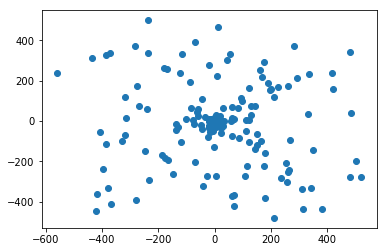

In [51]:
plt.scatter([list(particles.best_position.values())[ii]['0'] for ii in range(particles.nop)],
            [list(particles.best_position.values())[ii]['1'] for ii in range(particles.nop)])

In [52]:
fitness_function['griewank']([particles.member[list(particles.best_position.keys())[0]]['position'][str(jj)] for jj in range(len(particles.lowerbounds))])

0.6759463919785613

In [53]:
particles.func([particles.member[list(particles.best_position.keys())[0]]['position'][str(jj)] for jj in range(len(particles.lowerbounds))])

0.6759463919785613

In [54]:
[particles.member[list(particles.best_position.keys())[0]]['position'][str(jj)] for jj in range(len(particles.lowerbounds))]

[-5.067593916247094, -0.44739715276281977]

In [55]:
particles.member[list(particles.best_position.keys())[0]]['fitness_value']

0.6759463919785613

In [56]:
particles.fitness_values['_'][list(particles.best_position.keys())[0]]

0.6759463919785613

In [57]:
particles.fitness_values['best'][list(particles.best_position.keys())[0]]

0.04177089870752948

In [58]:
particles.member[list(particles.best_position.keys())[0]]

{'center': (-5, 0),
 'best_value': 0.04177089870752948,
 'position': {'0': -5.067593916247094, '1': -0.44739715276281977},
 'best_position': {'0': 0.00786418332589811, '1': 8.579631858503216},
 'velocity': {'0': -11.054947869326302, '1': -7.680618513738606},
 'fitness_value': 0.6759463919785613,
 'distance': {'0': {'0': -387.32485475369185, '1': 357.19461943052545},
  '1': {'0': 173.91102670200723, '1': 241.44834976746998},
  '2': {'0': -15.35730857845586, '1': 20.936938230582},
  '3': {'0': 17.743654163595533, '1': -196.03063327109547},
  '4': {'0': 49.849648956306766, '1': -3.164261803107415},
  '5': {'0': -110.4072853464614, '1': -16.906637566054698},
  '6': {'0': 281.87180707799763, '1': -414.6128646701009},
  '7': {'0': 523.5268321194743, '1': 32.89739625759233},
  '8': {'0': -154.72485089047981, '1': -54.15037128901473},
  '9': {'0': 86.45901977624557, '1': -3.8823009597072247},
  '10': {'0': -180.16020817185571, '1': -295.2549800162112},
  '11': {'0': -412.9379007210346, '1': -2

In [ ]:
# Particle Swarm Optimization (PSO) Code%% Girdiler
minimization = 1             # 0: maximization, 1: minimization
coeff        = 1.0           # katsayı // 1.0
w            = 0.0196        # weight of the partical velocity  //w    = 0.0196;
eta1         = 3.9804        # eta1 = 3.9804 // partical best
eta2         = 0.2157        # eta2 = 0.2157   // global best
eta3         = 3.2353        # eta3 = 3.2353  // closest neighbour
eta4         = 0.5098        # eta4 = 0.5098 // closest best neighbour
eta5         = 0.00          # eta5 = 0.00 // average position of the swarm
eta6         = 0.00          # eta6 = 0.00 // average velocity of the swarm
#fitness_function = @egg;    # the function that will be optimized
number_of_particles = 150    # The number of the elements (particles/bees/ants/birds) inside the swarm
number_of_variables = 2      # variable sayısı / dimension sayısı
migration           = 1      # 0: no-migration, 1: migration
pmig                = 0.15   # migration probability if migration is allowed // 0.15
mig_katsayi         = 0.0110 # migration katsayısı // = pmig (0.15)
objective_number    = 1      # the number of the objectives that the fitness function gives out
iteration           = 200    # Number of iterations
saved_data          = 1      # 1: use saved x_encoded values, 0: start randomly

In [ ]:
lower_boundaries = zeros(1,number_of_variables);
upper_boundaries = zeros(1,number_of_variables);

lower_boundaries(1,:) = [-512 -512];
upper_boundaries(1,:) = [512 512];
% lower_boundaries(1,:) = 0 * ones(1,number_of_variables);
% upper_boundaries(1,:) = 100 * ones(1,number_of_variables);
vel_min = -20;
vel_max = 20;

position = zeros(number_of_particles,number_of_variables);
velocity = zeros(number_of_particles,number_of_variables);
[row col] = size(position);          %%% size of the domain row: number of particles, col: number of variables
globalbest_value(1,1:col) = 1000000;

distances = zeros(number_of_particles,number_of_particles);
distances(1:number_of_particles,1:number_of_particles*number_of_variables) = 0;
closest_distances(1:number_of_particles,1:4*number_of_variables) = 1000000000;     %%% Her bir particle'�n kendisi dahil en yak�n 4 tane kom�usu i�in mesafeler bulunuyor.
closest_particles(1:number_of_particles,1:4*number_of_variables) = 0;

%%%% Kaydedilmi� veri kullan�lmadan, rastgele bir ver iseti ile ba�lan�yor %%%%

if(saved_data == 0)
    %%
    %%% Her bir partical i�in rastgele pozisyon (x1, x2, ..., xn)  ve h�z
    %%% atamas� yap�l�yor.
    for i = 1:row
        for j = 1:col
            position(i,j) = (upper_boundaries(1,j) - lower_boundaries(1,j)) * random('unif',0,1) + lower_boundaries(1,j);
            velocity(i,j) = random('unif',0,1);
        end
        fitness_values(i,:) = fitness_function(position(i,:));
    end
    personal_best_pos = position;
    
    total_velocity   = zeros(1,col);
    total_position   = zeros(1,col);
    average_velocity = zeros(1,col);
    average_position = zeros(1,col);
    for j = 1:col
        for i = 1:row
            total_velocity(1,j) = total_velocity(1,j) + velocity(i,j);
            total_position(1,j) = total_position(1,j) + position(i,j);
        end
        average_velocity(1,j) = total_velocity(1,j) / row;
        average_position(1,j) = total_position(1,j) / row;
    end
    
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%
    %%% Her bir partical'�n di�er partical'la ile aras�ndaki mesafe her bir variable i�in ayr� ayr� bulunuyor %%%
    for j = 1:col
        for i = 1:row
            for k = 1:row
                column = (j-1)*row + k;
                distances(i,column) = abs(position(i,j) - position(k,j));
            end
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%
    %%% Her bir particle'�n kendisi dahil en yak�n 4 tane kom�usu i�in
    %%% mesafeler ve partical indisleri bulunuyor. %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    for j = 1:col
        for i=1:row
            column = (j-1)*row ;
            sorted_neighbours(i,column+1:column+row) = sort(distances(i,column+1:column+row));
        end
    end
    
    for j = 1:col
        for i=1:row
            column = (j-1)*row ;
            sutun = (j-1) * 4;
            closest_distances(i,sutun+1:sutun+4) = sorted_neighbours(i,column+1:column+4);
        end
    end
    for j = 1:col
        for i=1:row
            for k=1:4
                column = (j-1)*row;
                sutun = (j-1) * 4 + k;
                closest_particles(i,sutun) = find(closest_distances(i,sutun) == distances(i,column+1:column+row),1,'first');
            end
        end
    end
    
    %%
    %%% Her bir partical i�in, o zaman kadar elde edilmi� en iyi fitness
    %%% de�eri kaydediliyor.
    for ii=1:row
        partical_best(ii,:) = fitness_function(position(ii,:));
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%%%%% En yak�n 4 particle'�n fitness de�erleri yaz�l�yor %%%%%%%%%%%%%
    for j = 1:col
        for i=1:row
            for k=1:4
                sutun = (j-1) * 4 + k;
                closest_particles_fitness_values(i,sutun) = fitness_values(closest_particles(i,sutun),1);
            end
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%%%% En yak�n 4 partical'�n fitness de�erleri ve particle'lar�n indisleri her bir variable i�in
    %%%%% en alttan en yukar�ya do�ru s�ralan�yor
    
    %%% En yak�n particle'lar�n fitness de�erleri s�ralan�yor
    closest_particles_fitness_values_sorted(:,:) = closest_particles_fitness_values(:,:);
    for j = 1:col
        for i=1:row
            sutun = (j-1) * 4 ;
            sorted_fitness_values(i,sutun+2:sutun+4) = sort(closest_particles_fitness_values(i,sutun+2:sutun+4));
        end
    end
    for j = 1:col
        for i=1:row
            sutun = (j-1) * 4 ;
            closest_particles_fitness_values_sorted(i,sutun+2:sutun+4) = sorted_fitness_values(i,sutun+2:sutun+4);
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%% En yak�n particle'lar�n indisleri s�ralan�yor
    for j = 1:col
        for i=1:row
            sutun = (j-1) * 4 ;
            closest_best_particles_indices(i,j) = closest_particles(i,find(closest_particles_fitness_values_sorted(i,sutun+2)==closest_particles_fitness_values(i,sutun+1:sutun+4),1,'first')+sutun);
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%
    %%%%% Global en iyi fitness de�eri bulunuyor
    if(minimization == 1)
        for ii=1:row
            if (partical_best(ii,:) < globalbest_value)
                globalbest_value = partical_best(ii,:);
                global_best_index = ii;
                global_best_position = position(global_best_index,:);
            end
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    genn = 1;
    %%
    %%% kaydedilmi� veri kullan�l�yor
else
    load('PSO_saved_data.mat');
    [saved_data_birey_sayisi saved_data_col] = size(fitness_values);
    genn = genn_saved;
    if(row>saved_data_birey_sayisi)
        for i = saved_data_birey_sayisi+1:row
            for j = 1:col
                position(i,j) = (upper_boundaries(1,j) - lower_boundaries(1,j)) * random('unif',0,1) + lower_boundaries(1,j);
                velocity(i,j) = random('unif',0,1);
            end
            fitness_values(i,:) = fitness_function(position(i,:));
            personal_best_pos(i,:) = position(i,:);
        end
        %%
        %%% Her bir partical'�n di�er partical'la ile aras�ndaki mesafe her bir variable i�in ayr� ayr� bulunuyor %%%
        for j = 1:col
            for i = 1:row
                for k = 1:row
                    column = (j-1)*row + k;
                    distances(i,column) = abs(position(i,j) - position(k,j));
                end
            end
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        %%
        %%% Her bir particle'�n kendisi dahil en yak�n 4 tane kom�usu i�in
        %%% mesafeler ve partical indisleri bulunuyor. %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        for j = 1:col
            for i=1:row
                column = (j-1)*row ;
                sorted_neighbours(i,column+1:column+row) = sort(distances(i,column+1:column+row));
            end
        end
        
        for j = 1:col
            for i=1:row
                column = (j-1)*row ;
                sutun = (j-1) * 4;
                closest_distances(i,sutun+1:sutun+4) = sorted_neighbours(i,column+1:column+4);
            end
        end
        for j = 1:col
            for i=1:row
                for k=1:4
                    column = (j-1)*row;
                    sutun = (j-1) * 4 + k;
                    closest_particles(i,sutun) = find(closest_distances(i,sutun) == distances(i,column+1:column+row),1,'first');
                end
            end
        end
        
        %%
        %%% Her bir partical i�in, o zaman kadar elde edilmi� en iyi fitness
        %%% de�eri kaydediliyor.
        for ii=saved_data_birey_sayisi+1:row
            partical_best(ii,:) = fitness_function(position(ii,:));
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        %%%%%% En yak�n 4 particle'�n fitness de�erleri yaz�l�yor %%%%%%%%%%%%%
        for j = 1:col
            for i=1:row
                for k=1:4
                    sutun = (j-1) * 4 + k;
                    closest_particles_fitness_values(i,sutun) = fitness_values(closest_particles(i,sutun),1);
                end
            end
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        %%%%% En yak�n 4 partical'�n fitness de�erleri ve particle'lar�n indisleri her bir variable i�in
        %%%%% en alttan en yukar�ya do�ru s�ralan�yor
        
        %%% En yak�n particle'lar�n fitness de�erleri s�ralan�yor
        closest_particles_fitness_values_sorted(:,:) = closest_particles_fitness_values(:,:);
        for j = 1:col
            for i=1:row
                sutun = (j-1) * 4 ;
                sorted_fitness_values(i,sutun+2:sutun+4) = sort(closest_particles_fitness_values(i,sutun+2:sutun+4));
            end
        end
        for j = 1:col
            for i=1:row
                sutun = (j-1) * 4 ;
                closest_particles_fitness_values_sorted(i,sutun+2:sutun+4) = sorted_fitness_values(i,sutun+2:sutun+4);
            end
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        %%% En yak�n particle'lar�n indisleri s�ralan�yor
        for j = 1:col
            for i=1:row
                sutun = (j-1) * 4 ;
                closest_best_particles_indices(i,j) = closest_particles(i,find(closest_particles_fitness_values_sorted(i,sutun+2)==closest_particles_fitness_values(i,sutun+1:sutun+4),1,'first')+sutun);
            end
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        %%
        %%%%% Global en iyi fitness de�eri bulunuyor
        if(minimization == 1)
            for ii=1:row
                if (partical_best(ii,:) < globalbest_value)
                    globalbest_value = partical_best(ii,:);
                    global_best_index = ii;
                    global_best_position = position(global_best_index,:);
                end
            end
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    end
end

scatterplot(position(:,1:2));

iter = 0;

%%
%%%%%%% iterasyonlar ba�l�yor
while(iter < iteration)
    remainder = rem(iter,10);
    %%
    %%% Pozisyon ve h�z de�erleri g�ncelleniyor.
    for ii=1:row
        
        for jj=1:col
            velocity(ii,jj) = coeff * (w * velocity(ii,jj) ...
                + eta1 * random('unif',0,1) * (personal_best_pos(ii,jj) - position(ii,jj))...
                + eta2 * random('unif',0,1) * (global_best_position(:,jj) - position(ii,jj)))...
                + eta3 * random('unif',0,1) * (position(closest_particles(ii,(jj-1)*4+2),jj) - position(ii,jj))...
                + eta4 * random('unif',0,1) * (position(closest_best_particles_indices(ii,jj) ,jj) - position(ii,jj))...
                + eta5 * random('unif',0,1) * (average_position(1,jj) - position(ii,jj))...
                + eta6 * random('unif',0,1) * average_velocity(1,jj);
            
            if(velocity(ii,jj)>vel_max)
                velocity(ii,jj) = vel_max;
            elseif(velocity(ii,jj)<vel_min)
                velocity(ii,jj) = vel_min;
            end
            
            position(ii,jj) = position(ii,jj) + velocity(ii,jj);
            
            if(position(ii,jj)>upper_boundaries(1,jj))
                position(ii,jj) = upper_boundaries(1,jj);
            elseif(position(ii,jj)<lower_boundaries(1,jj))
                position(ii,jj) = lower_boundaries(1,jj);
            end
        end
        
        fitness_values(ii,:) = fitness_function(position(ii,:));
        
        if(fitness_values(ii,:) < partical_best(ii,:))
            partical_best(ii,:) = fitness_values(ii,:);
            personal_best_pos(ii,:) = position(ii,:);
        end
        
        if (partical_best(ii,:) < globalbest_value)
            globalbest_value = partical_best(ii,:);
            global_best_index = ii;
            global_best_position = position(global_best_index,:);
        end
        
        total_velocity   = zeros(1,col);
        total_position   = zeros(1,col);
        average_velocity = zeros(1,col);
        average_position = zeros(1,col);
        for j = 1:col
            for i = 1:row
                total_velocity(1,j) = total_velocity(1,j) + velocity(i,j);
                total_position(1,j) = total_position(1,j) + position(i,j);
            end
            average_velocity(1,j) = total_velocity(1,j) / row;
            average_position(1,j) = total_position(1,j) / row;
        end
    end
    %%
    %%%% Migration eklemesi yap�l�yor e�er migration=1 ise %%%
    if(migration==1)
        migration_probability = random('unif',0,1);
        total_migrating_particle_number = round(pmig*number_of_particles+objective_number);
        migrating_particle_number1 = round((pmig*number_of_particles+objective_number)/4);
        migrating_particle_number2 = 2 * migrating_particle_number1;
        migrating_particle_number3 = 3 * migrating_particle_number1;
        if(migration_probability <= pmig)
            sorted = sort(fitness_values(:,objective_number),'descend');
            
            %%% Fitness de�eri en d���k olan particle'lar�n indeksleri
            %%% bulunuyor
            for wi=1:total_migrating_particle_number
                worst_indeks(wi,1) = find(fitness_values(:,objective_number)==sorted(wi,1),1,'first');
            end
            
            %%% Fitness de�eri en y�ksek olan particle'lar�n indeksleri
            %%% bulunuyor
            for bi=1:(0.20*number_of_particles)
                best_indeks(bi,1) = find(fitness_values(:,objective_number)==sorted(number_of_particles+1-bi,1),1,'first');
                best_particle_array(bi,:) = position(best_indeks(bi,1),:);
            end
            
            %%% Fitness de�eri en y�ksek particle'lar�n average
            %%% pozisyonlar� bulunuyor.
            for j=1:col
                best_particles_average_position(1,j) = averaging(best_particle_array(:,j));
            end
            
            %%% En k�t� fitness de�erine sahip olanlar�n yar�s�, random
            %%% particle'lar ile de�i�tiriliyor
            for i = 1:migrating_particle_number1
                for j = 1:col
                    position(worst_indeks(i),j) = (upper_boundaries(1,j) - lower_boundaries(1,j)) * random('unif',0,1) + lower_boundaries(1,j);
                    velocity(worst_indeks(i),j) = random('unif',0,1);
                end
            end
            
            %%% En k�t� fitness de�erine sahip olanlar�n kalan yar�s�, en
            %%% iyi particle'lar�n ortalama pozisyon ve h�z de�eri merkez
            %%% al�narak random pozisyon ve h�z de�erlerine sahip yeni
            %%% particle'lar ile de�i�tiriliyor.
            for i = migrating_particle_number1+1:migrating_particle_number2
                for j = 1:col
                    sign = 1;
                    rastgelelik = random('unif',0,1);
                    if(rastgelelik < 0.50)
                        sign = -1;
                    end
                    position(worst_indeks(i),j) = 0.10 * (upper_boundaries(1,j) - lower_boundaries(1,j)) * random('unif',0,1) + sign * best_particles_average_position(1,j);
                    velocity(worst_indeks(i),j) = random('unif',0,1) * average_velocity(1,j);
                    
                    if(position(worst_indeks(i),j)>upper_boundaries(1,j))
                        position(worst_indeks(i),j) = upper_boundaries(1,j);
                    elseif(position(worst_indeks(i),j)<lower_boundaries(1,j))
                        position(worst_indeks(i),j) = lower_boundaries(1,j);
                    end
                    
                end
            end
            for i = migrating_particle_number2+1:migrating_particle_number3
                for j = 1:col
                    sign = 1;
                    rastgelelik = random('unif',0,1);
                    if(rastgelelik < 0.50)
                        sign = -1;
                    end
                    position(worst_indeks(i),j) = 10 * (best_particle_array(1,j) - best_particle_array(end,j)) * random('unif',0,1) + sign * best_particles_average_position(1,j);
                    velocity(worst_indeks(i),j) = random('unif',0,1) * average_velocity(1,j);
                    
                    if(position(worst_indeks(i),j)>upper_boundaries(1,j))
                        position(worst_indeks(i),j) = upper_boundaries(1,j);
                    elseif(position(worst_indeks(i),j)<lower_boundaries(1,j))
                        position(worst_indeks(i),j) = lower_boundaries(1,j);
                    end
                    
                end
            end
            for i = migrating_particle_number3+1:total_migrating_particle_number
                for j = 1:col
                    sign = 1;
                    rastgelelik = random('unif',0,1);
                    if(rastgelelik < 0.50)
                        sign = -1;
                    end
                    position(worst_indeks(i),j) = 2.0 * (best_particles_average_position(1,j) - average_position(1,j)) * random('unif',0,1) + sign * global_best_position(1,j);
                    velocity(worst_indeks(i),j) = random('unif',0,1) * average_velocity(1,j);
                    
                    if(position(worst_indeks(i),j)>upper_boundaries(1,j))
                        position(worst_indeks(i),j) = upper_boundaries(1,j);
                    elseif(position(worst_indeks(i),j)<lower_boundaries(1,j))
                        position(worst_indeks(i),j) = lower_boundaries(1,j);
                    end
                    
                end
            end
            
        end
        clear worst_indeks;
    end
    %%
    %%% Her bir partical'�n di�er partical'la ile aras�ndaki mesafe her bir variable i�in ayr� ayr� bulunuyor %%%
    for j = 1:col
        for i = 1:row
            for k = 1:row
                column = (j-1)*row + k;
                distances(i,column) = abs(position(i,j) - position(k,j));
            end
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%
    %%% Her bir particle'�n kendisi dahil en yak�n 4 tane kom�usu i�in
    %%% mesafeler ve partical indisleri bulunuyor. %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    for j = 1:col
        for i=1:row
            column = (j-1)*row ;
            sorted_neighbours(i,column+1:column+row) = sort(distances(i,column+1:column+row));
        end
    end
    
    for j = 1:col
        for i=1:row
            column = (j-1)*row ;
            sutun = (j-1) * 4;
            closest_distances(i,sutun+1:sutun+4) = sorted_neighbours(i,column+1:column+4);
        end
    end
    for j = 1:col
        for i=1:row
            for k=1:4
                column = (j-1)*row;
                sutun = (j-1) * 4 + k;
                closest_particles(i,sutun) = find(closest_distances(i,sutun) == distances(i,column+1:column+row),1,'first');
            end
        end
    end
    
    %%
    %%% Her bir partical i�in, o zaman kadar elde edilmi� en iyi fitness
    %%% de�eri kaydediliyor.
    for ii=1:row
        partical_best(ii,:) = fitness_function(position(ii,:));
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%%%%% En yak�n 4 particle'�n fitness de�erleri yaz�l�yor %%%%%%%%%%%%%
    for j = 1:col
        for i=1:row
            for k=1:4
                sutun = (j-1) * 4 + k;
                closest_particles_fitness_values(i,sutun) = fitness_values(closest_particles(i,sutun),1);
            end
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%%%% En yak�n 4 partical'�n fitness de�erleri ve particle'lar�n indisleri her bir variable i�in
    %%%%% en alttan en yukar�ya do�ru s�ralan�yor
    
    %%% En yak�n particle'lar�n fitness de�erleri s�ralan�yor
    closest_particles_fitness_values_sorted(:,:) = closest_particles_fitness_values(:,:);
    for j = 1:col
        for i=1:row
            sutun = (j-1) * 4 ;
            sorted_fitness_values(i,sutun+2:sutun+4) = sort(closest_particles_fitness_values(i,sutun+2:sutun+4));
        end
    end
    for j = 1:col
        for i=1:row
            sutun = (j-1) * 4 ;
            closest_particles_fitness_values_sorted(i,sutun+2:sutun+4) = sorted_fitness_values(i,sutun+2:sutun+4);
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%% En yak�n particle'lar�n indisleri s�ralan�yor
    for j = 1:col
        for i=1:row
            sutun = (j-1) * 4 ;
            closest_best_particles_indices(i,j) = closest_particles(i,find(closest_particles_fitness_values_sorted(i,sutun+2)==closest_particles_fitness_values(i,sutun+1:sutun+4),1,'first')+sutun);
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %%
    
    if (remainder == 1)
        scatterplot(position(:,1:2));
    end
    
    best_value_array(genn,1) = globalbest_value;
    
    genn = genn + 1;
    iter = iter + 1;
    text1 = 'iter = %d\n';
    fprintf(text1,iter);
    
end
genn_saved = genn;
save('PSO_saved_data.mat','position','velocity','closest_distances','closest_particles','globalbest_value','global_best_position','partical_best','personal_best_pos','closest_best_particles_indices','average_velocity','average_position','fitness_values','genn_saved','best_value_array');
close all;
scatterplot(position(:,1:2));